In [1]:
import os
import pickle
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import tqdm

2024-05-26 22:41:04.399847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 22:41:04.399952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 22:41:04.532800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set plot style
plt.style.use("Solarize_Light2")
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

In [3]:
def build_files_list(root_dir, normal_dir="normal", abnormal_dir="anomaly"):
    """
    Builds lists of file paths for normal and abnormal audio files.

    Args:
        root_dir (str): The root directory containing the data.
        normal_dir (str, optional): The directory name for normal audio files. Defaults to "normal".
        abnormal_dir (str, optional): The directory name for abnormal audio files. Defaults to "abnormal".

    Returns:
        tuple: A tuple containing two lists:
            - normal_files: A list of file paths for normal audio files.
            - abnormal_files: A list of file paths for abnormal audio files.
    """
    normal_files = []
    abnormal_files = []

    for root, _, files in os.walk(top=root_dir):
        for file in files:
            if normal_dir in root:
                normal_files.append(os.path.join(root, file))
            elif abnormal_dir in root:
                abnormal_files.append(os.path.join(root, file))

    return normal_files, abnormal_files


def extract_signal_features(
    signal, sr, n_fft=1024, hop_length=512, n_mels=64, frames=5
):
    """
    Extracts Mel spectrogram features from an audio signal.

    Args:
        signal (np.ndarray): The audio signal.
        sr (int): The sampling rate of the audio signal.
        n_fft (int, optional): The length of the FFT window. Defaults to 1024.
        hop_length (int, optional): The number of samples between successive frames. Defaults to 512.
        n_mels (int, optional): The number of Mel bands to generate. Defaults to 64.
        frames (int, optional): The number of frames to stack. Defaults to 5.

    Returns:
        np.ndarray: The extracted features.
    """
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(
        mel_spectrogram, ref=np.max
    )

    features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
    dims = frames * n_mels

    if features_vector_size < 1:
        return np.empty((0, dims), np.float32)

    features = np.zeros((features_vector_size, dims), np.float32)
    for t in range(frames):
        features[:, n_mels * t : n_mels * (t + 1)] = log_mel_spectrogram[
            :, t : t + features_vector_size
        ].T

    return features


def generate_dataset(files_list, n_fft=1024, hop_length=512, n_mels=64, frames=5):
    """
    Generates a dataset of Mel spectrogram features from a list of audio files.

    Args:
        files_list (list): A list of file paths for audio files.
        n_fft (int, optional): The length of the FFT window. Defaults to 1024.
        hop_length (int, optional): The number of samples between successive frames. Defaults to 512.
        n_mels (int, optional): The number of Mel bands to generate. Defaults to 64.
        frames (int, optional): The number of frames to stack. Defaults to 5.

    Returns:
        np.ndarray: The generated dataset.
    """
    dims = n_mels * frames

    for index, file in enumerate(tqdm(files_list, desc="Extracting Features")):
        signal, sr = librosa.load(file, sr=None, mono=True)
        features = extract_signal_features(
            signal,
            sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            frames=frames,
        )

        if index == 0:
            dataset = np.zeros((features.shape[0] * len(files_list), dims), np.float32)

        dataset[
            features.shape[0] * index : features.shape[0] * (index + 1), :
        ] = features

    return dataset


def load_sound_file(path, mono=False, channel=0):
    """
    Loads an audio file.

    Args:
        path (str): The path to the audio file.
        mono (bool, optional): Whether to load the audio as mono. Defaults to False.
        channel (int, optional): The channel to load if mono is False. Defaults to 0.

    Returns:
        tuple: A tuple containing:
            - signal (np.ndarray): The audio signal.
            - sr (int): The sampling rate of the audio signal.
    """
    signal, sr = librosa.load(path, sr=None, mono=mono)

    if signal.ndim < 2:
        return signal, sr
    else:
        return signal[channel, :], sr

In [4]:
# Data paths
DATA_PATH = "/kaggle/input/dcase-aml/dev_data/dev_data/slider"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(DATA_PATH, "test")
TRAIN_EVAL_PATH = "/kaggle/input/dcase-aml/eval_data/eval_data/slider/train"
MODEL_PATH = "./models"

In [5]:
# Build file lists
test_files_abnormal = glob.glob(os.path.join(TEST_PATH, 'anomaly_id_*.wav'))
test_files_normal = glob.glob(os.path.join(TEST_PATH, 'normal_id_*.wav'))
normal_files = glob.glob(os.path.join(TRAIN_PATH, 'normal_id_*.wav'))
normal_files_eval = glob.glob(os.path.join(TRAIN_EVAL_PATH, 'normal_id_*.wav'))

"""# Print the paths, or a message if no files are found
if abnormal_files:
    print("Abnormal files found:")
    for file in abnormal_files:
        print(file)
else:
    print("No abnormal files found.")

if normal_files:
    print("\nNormal files found:")
    for file in normal_files:
        print(file)
else:
    print("\nNo normal files found.")"""

'# Print the paths, or a message if no files are found\nif abnormal_files:\n    print("Abnormal files found:")\n    for file in abnormal_files:\n        print(file)\nelse:\n    print("No abnormal files found.")\n\nif normal_files:\n    print("\nNormal files found:")\n    for file in normal_files:\n        print(file)\nelse:\n    print("\nNo normal files found.")'

In [6]:
# Create dataset
# Combine normal files from both train sets
X_train = np.concatenate((normal_files, normal_files_eval), axis=0)
# Create labels for train data (all normal)
y_train = np.zeros(len(X_train))

# Combine test files for normal and abnormal
X_test = np.concatenate((test_files_normal, test_files_abnormal), axis=0)
# Create labels for test data
y_test = np.concatenate(
    (np.zeros(len(test_files_normal)), np.ones(len(test_files_abnormal))), axis=0
)

In [7]:
print(
    "Train set has {} signals including abnormal {:.0f} signals, but test set has {} signals including abnormal {:.0f} signals.".format(
        y_train.shape[0],
        y_train.sum(),
        y_test.shape[0],
        y_test.sum(),
    )
)

Train set has 4740 signals including abnormal 0 signals, but test set has 1101 signals including abnormal 801 signals.


In [8]:
# Set parameters 
n_fft = 2048
hop_length = 512
n_mels = 64
frames = 5

# Use the Kaggle working directory for saving the processed data
train_data_path = "train_data.pkl" 

# Generate training data
if os.path.exists(train_data_path):
    print("Train data already exists, loading from file...")
    with open(train_data_path, "rb") as f:
        train_data = pickle.load(f)
else:
    train_data = generate_dataset(
        X_train, 
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        frames=frames,
    )
    print("Saving training data to disk...")
    with open(train_data_path, "wb") as f:
        pickle.dump(train_data, f)
    print("Done.")

print(f"Train data has a {train_data.shape} shape.")

Extracting Features:   0%|          | 0/4740 [00:00<?, ?it/s]

Saving training data to disk...
Done.
Train data has a (1464660, 320) shape.


In [9]:
def autoencoder(input_dims):
    """
    Builds an autoencoder model.

    Args:
        input_dims (int): The input dimension.

    Returns:
        tf.keras.Model: The autoencoder model.
    """
    input_layer = Input(shape=(input_dims,))
    h = Dense(64, activation="relu")(input_layer)
    h = Dense(64, activation="relu")(h)
    h = Dense(8, activation="relu")(h)
    h = Dense(64, activation="relu")(h)
    h = Dense(64, activation="relu")(h)
    h = Dense(input_dims, activation=None)(h)

    return Model(inputs=input_layer, outputs=h, name="autoencoder")

In [10]:
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# Create and compile model
model = autoencoder(n_mels * frames)
print(model.summary())

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 320)            │        20,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,760 (198.28 KB)

 Trainable params: 50,760 (198.28 KB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
# Train model
batch_size = 128
epochs = 100

model.compile(optimizer=Adam(learning_rate=1e-03), loss="mean_squared_error")

history = model.fit(
    train_data,
    train_data,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)],
    validation_data=(train_data, train_data),  # Use test_data for validation
    verbose=True,
    shuffle=True,
)

# Save model
os.makedirs(MODEL_PATH, exist_ok=True)
model.save(os.path.join(MODEL_PATH, "autoencoder.h5"))

Epoch 1/100
   86/11443 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 383.3411

I0000 00:00:1716763444.843555      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11443/11443 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 22.2709 - val_loss: 13.6955
Epoch 2/100
11443/11443 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 13.6211 - val_loss: 13.5759
Epoch 3/100
11443/11443 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 13.5756 - val_loss: 13.3413
Epoch 4/100
11443/11443 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 13.1815 - val_loss: 12.9278
Epoch 5/100
11443/11443 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 12.5386 - val_loss: 8.5461
Epoch 6/100
11443/11443 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 8.3426 - val_loss: 7.7926
Epoch 7/100
11443/11443 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 7.7107 - val_loss: 7.4946
Epoch 8/100
11443/11443 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 7.4590 - val_loss: 7.2156
Epoch 9/100
11443/11443 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 7.3243 - val_loss: 7.3109
Epoch 10/100
11443/11443 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 7.2832 - val_loss: 6.9690
Epoch 11/100
11443/11443 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 6.9089 - val_lo

In [13]:
# Evaluate model
reconstruction_errors = []

for index in tqdm(range(len(X_test))):
    signal, sr = load_sound_file(X_test[index])

    features = extract_signal_features(
        signal,
        sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        frames=frames,
    )

    prediction = model.predict(features)
    mse = np.mean(np.mean(np.square(features - prediction), axis=1))
    reconstruction_errors.append(mse)

  0%|          | 0/1101 [00:00<?, ?it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


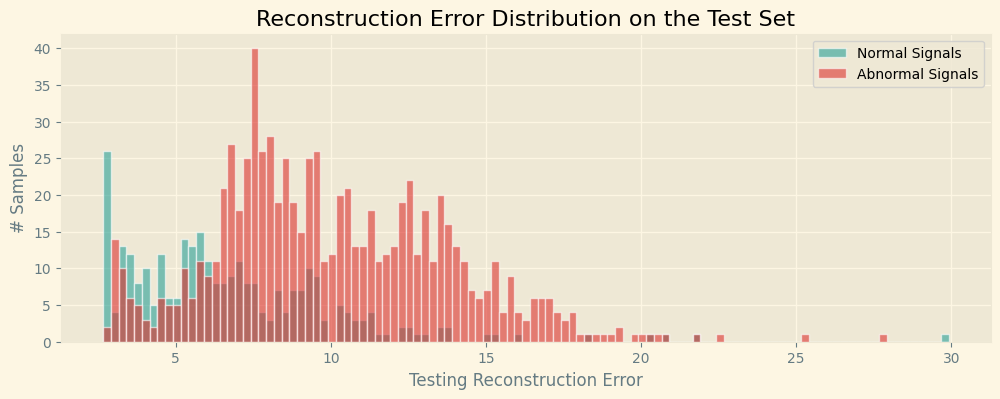

In [14]:
# Plot reconstruction error distribution
y_true = y_test
data = np.column_stack((range(len(reconstruction_errors)), reconstruction_errors))
bin_width = 0.25
bins = np.arange(
    min(reconstruction_errors), max(reconstruction_errors) + bin_width, bin_width
)

fig = plt.figure(figsize=(12, 4))
plt.hist(
    data[y_true == 0][:, 1],
    bins=bins,
    color=colors[1],
    alpha=0.6,
    label="Normal Signals",
    edgecolor="#FFFFFF",
)
plt.hist(
    data[y_true == 1][:, 1],
    bins=bins,
    color=colors[5],
    alpha=0.6,
    label="Abnormal Signals",
    edgecolor="#FFFFFF",
)
plt.xlabel("Testing Reconstruction Error")
plt.ylabel("# Samples")
plt.title("Reconstruction Error Distribution on the Test Set", fontsize=16)
plt.legend()
plt.show()

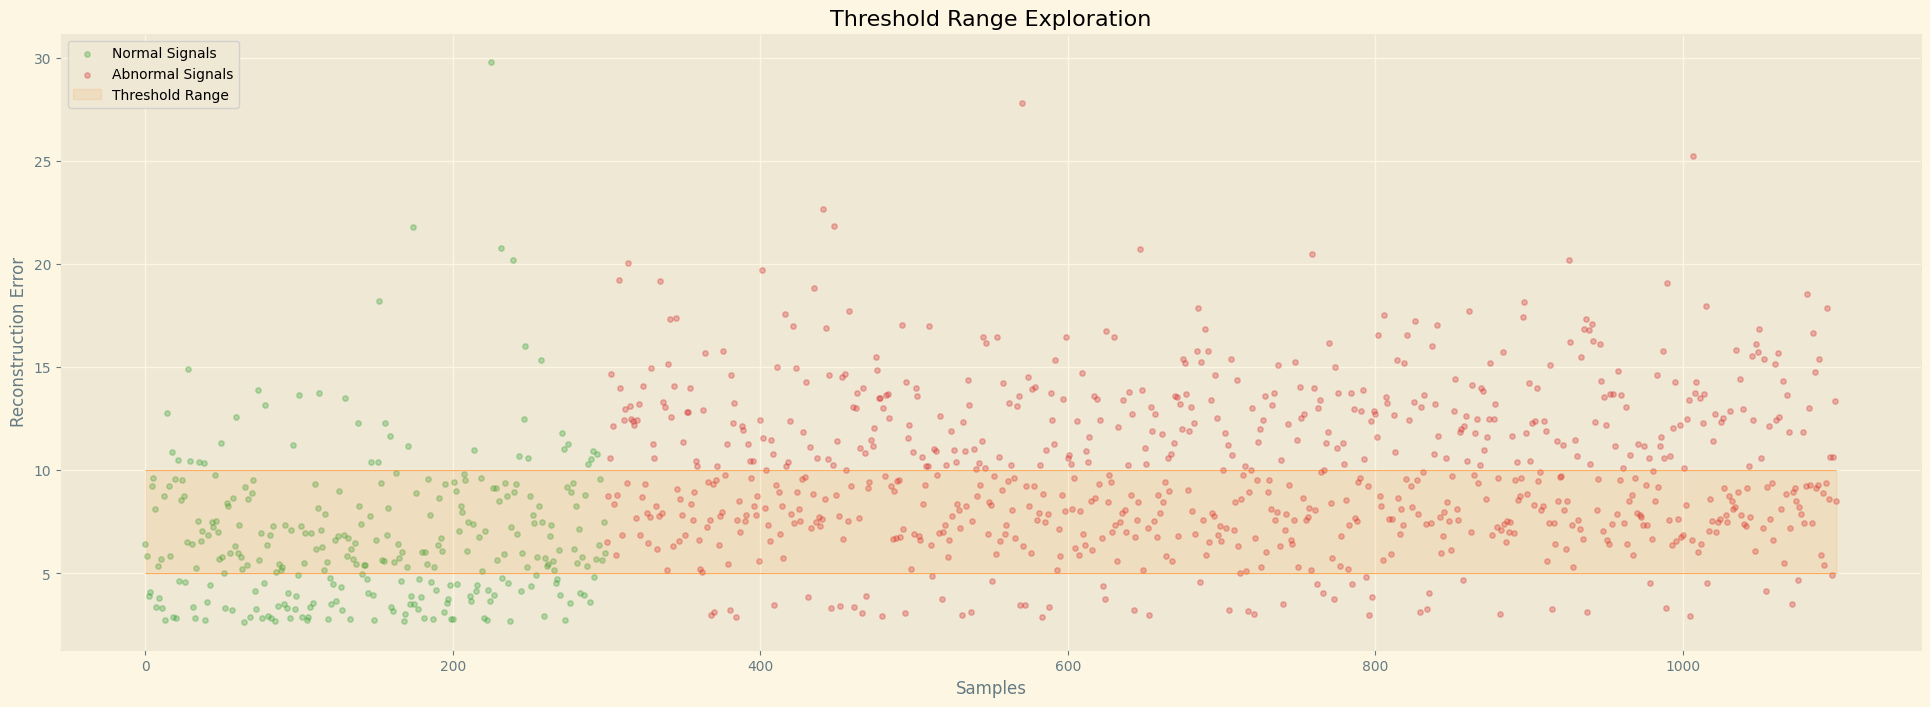

In [15]:
# Plot threshold range exploration
threshold_min = 5.0
threshold_max = 10.0
threshold_step = 0.50

normal_x, normal_y = (
    data[y_true == 0][:, 0],
    data[y_true == 0][:, 1],
)
abnormal_x, abnormal_y = (
    data[y_true == 1][:, 0],
    data[y_true == 1][:, 1],
)
x = np.concatenate((normal_x, abnormal_x))

fig, ax = plt.subplots(figsize=(24, 8))
plt.scatter(
    normal_x,
    normal_y,
    s=15,
    color="tab:green",
    alpha=0.3,
    label="Normal Signals",
)
plt.scatter(
    abnormal_x,
    abnormal_y,
    s=15,
    color="tab:red",
    alpha=0.3,
    label="Abnormal Signals",
)
plt.fill_between(
    x, threshold_min, threshold_max, alpha=0.1, color="tab:orange", label="Threshold Range"
)
plt.hlines(
    [threshold_min, threshold_max],
    x.min(),
    x.max(),
    linewidth=0.5,
    alpha=0.8,
    color="tab:orange",
)
plt.legend(loc="upper left")
plt.title("Threshold Range Exploration", fontsize=16)
plt.xlabel("Samples")
plt.ylabel("Reconstruction Error")
plt.show()

In [16]:
def generate_error_types(
    df,
    ground_truth_col="Ground Truth",
    prediction_col="Prediction",
    normal_label=0.0,
    anomaly_label=1.0,
):
    """
    Compute false positive and false negatives columns based on the prediction
    and ground truth columns from a dataframe.

    Args:
        df (pd.DataFrame): Dataframe where the ground truth and prediction columns are available.
        ground_truth_col (str, optional): Column name for the ground truth values. Defaults to "Ground Truth".
        prediction_col (str, optional): Column name for the predicted values. Defaults to "Prediction".
        normal_label (object, optional): Value taken by a normal value. Defaults to 0.0.
        anomaly_label (object, optional): Value taken by an abnormal value. Defaults to 1.0.

    Returns:
        pd.DataFrame: An updated dataframe with 4 new binary columns for TP, TN, FP and FN.
    """
    df["TP"] = 0
    df["TN"] = 0
    df["FP"] = 0
    df["FN"] = 0
    df.loc[
        (df[ground_truth_col] == df[prediction_col])
        & (df[ground_truth_col] == normal_label),
        "TP",
    ] = 1
    df.loc[
        (df[ground_truth_col] == df[prediction_col])
        & (df[ground_truth_col] == anomaly_label),
        "TN",
    ] = 1
    df.loc[
        (df[ground_truth_col] != df[prediction_col])
        & (df[ground_truth_col] == normal_label),
        "FP",
    ] = 1
    df.loc[
        (df[ground_truth_col] != df[prediction_col])
        & (df[ground_truth_col] == anomaly_label),
        "FN",
    ] = 1

    return df


def plot_curves(FP, FN, nb_samples, threshold_min, threshold_max, threshold_step):
    """
    Plot the false positives and false negative samples number depending on a given threshold.

    Args:
        FP (pd.DataFrame): Number of false positives depending on the threshold.
        FN (pd.DataFrame): Number of false negatives depending on the threshold.
        nb_samples (int): Total number of samples.
        threshold_min (float): Minimum threshold to plot for.
        threshold_max (float): Maximum threshold to plot for.
        threshold_step (float): Threshold step to plot these curves.
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    min_FN = np.argmin(FN)
    min_FP = np.where(FP == np.min(FP))[0][-1]
    plot_top = max(FP + FN) + 1

    # Grid customization:
    major_ticks = np.arange(threshold_min, threshold_max, 1.0 * threshold_step)
    minor_ticks = np.arange(threshold_min, threshold_max, 0.2 * threshold_step)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which="minor", alpha=0.5)
    ax.grid(which="major", alpha=1.0, linewidth=1.0)

    # Plot false positives and false negatives curves
    plt.plot(
        np.arange(threshold_min, threshold_max + threshold_step, threshold_step),
        FP,
        label="False positive",
        color="tab:red",
    )
    plt.plot(
        np.arange(threshold_min, threshold_max + threshold_step, threshold_step),
        FN,
        label="False negative",
        color="tab:green",
    )

    # Finalize the plot with labels and legend:
    plt.xlabel("Reconstruction error threshold (%)", fontsize=16)
    plt.ylabel("# Samples", fontsize=16)
    plt.legend()


def print_confusion_matrix(confusion_matrix, class_names, figsize=(4, 3), fontsize=14):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a heatmap.

    Args:
        confusion_matrix (np.ndarray): The numpy.ndarray object returned from a call to
            sklearn.metrics.confusion_matrix. Similarly constructed
            ndarrays can also be used.
        class_names (list): An ordered list of class names, in the order they index the given
            confusion matrix.
        figsize (tuple, optional): A 2-long tuple, the first value determining the horizontal size of
            the ouputted figure, the second determining the vertical size.
            Defaults to (10,7).
        fontsize (int, optional): Font size for axes labels. Defaults to 14.

    Returns:
        matplotlib.figure.Figure: The resulting confusion matrix figure.
    """
    # Build a dataframe from the confusion matrix passed as argument:
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    # Plot the confusion matrix:
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(
            df_cm, annot=True, fmt="d", annot_kws={"size": 16}, cmap="viridis"
        )
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    # Figure customization:
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0, ha="right", fontsize=fontsize
    )
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45, ha="right", fontsize=fontsize
    )
    plt.ylabel("True label", fontsize=16)
    plt.xlabel("Predicted label", fontsize=16)

    return fig

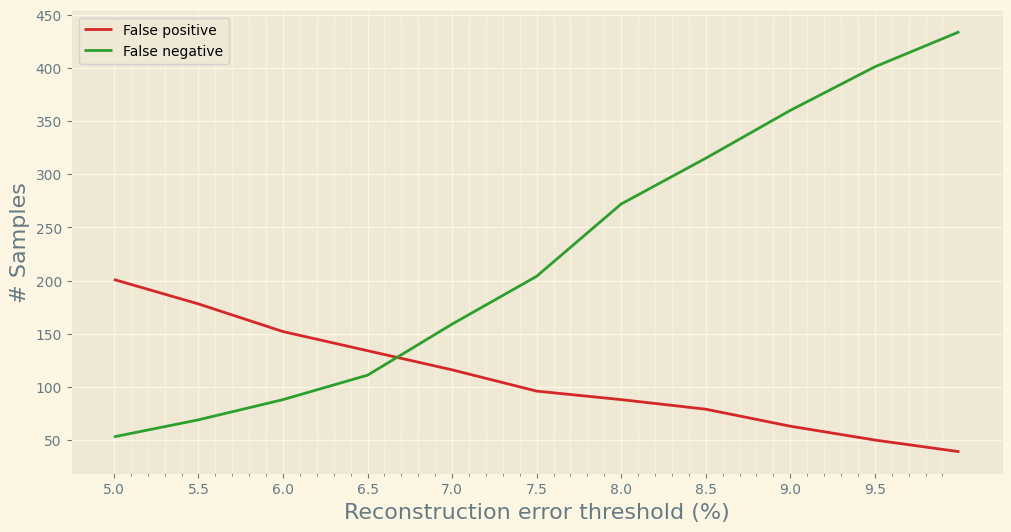

In [17]:
# Find optimal threshold
thresholds = np.arange(threshold_min, threshold_max + threshold_step, threshold_step)

df = pd.DataFrame(
    columns=["Signal", "Ground Truth", "Prediction", "Reconstruction Error"]
)
df["Signal"] = X_test
df["Ground Truth"] = y_test
df["Reconstruction Error"] = reconstruction_errors

FN = []
FP = []
for th in thresholds:
    df.loc[df["Reconstruction Error"] <= th, "Prediction"] = 0.0
    df.loc[df["Reconstruction Error"] > th, "Prediction"] = 1.0
    df = generate_error_types(df)
    FN.append(df["FN"].sum())
    FP.append(df["FP"].sum())

plot_curves(
    FP,
    FN,
    nb_samples=df.shape[0],
    threshold_min=threshold_min,
    threshold_max=threshold_max,
    threshold_step=threshold_step,
)

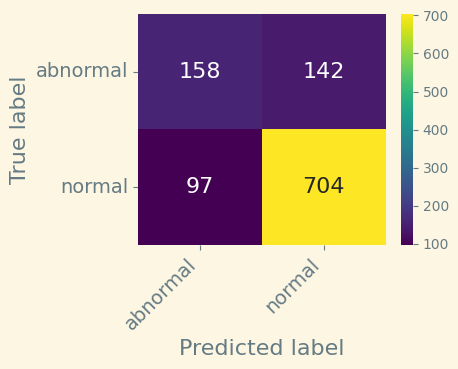

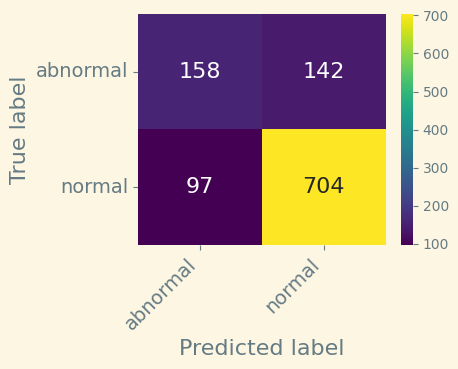

In [18]:
# Evaluate performance with chosen threshold
th = 6.275
df.loc[df["Reconstruction Error"] <= th, "Prediction"] = 0.0
df.loc[df["Reconstruction Error"] > th, "Prediction"] = 1.0
df["Prediction"] = df["Prediction"].astype(np.float32)
df = generate_error_types(df)
tp = df["TP"].sum()
tn = df["TN"].sum()
fn = df["FN"].sum()
fp = df["FP"].sum()

print_confusion_matrix(
    confusion_matrix(df["Ground Truth"], df["Prediction"]),
    class_names=["abnormal", "normal"],
)

In [19]:
# Calculate metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * precision * recall / (precision + recall)

print(
    f"""Basic autoencoder metrics:
- Precision: {precision*100:.1f}%
- Recall: {recall*100:.1f}%
- Accuracy: {accuracy*100:.1f}%
- F1 Score: {f1_score*100:.1f}%"""
)

Basic autoencoder metrics:
- Precision: 52.7%
- Recall: 62.0%
- Accuracy: 78.3%
- F1 Score: 56.9%


In [20]:
# Calculate AUC
print(f"AUC: {roc_auc_score(y_true, reconstruction_errors):.4f}")

AUC: 0.7662


In [21]:
class visualizer(object):
    def __init__(self):
        import matplotlib.pyplot as plt
        self.plt = plt
        self.fig = self.plt.figure(figsize=(30, 10))
        self.plt.subplots_adjust(wspace=0.3, hspace=0.3)

    def loss_plot(self, loss, val_loss):
        """
        Plot loss curve.
        loss : list [ float ]
            training loss time series.
        val_loss : list [ float ]
            validation loss time series.
        return   : None
        """
        ax = self.fig.add_subplot(1, 1, 1)
        ax.cla()
        ax.plot(loss)
        ax.plot(val_loss)
        ax.set_title("Model loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend(["Train", "Test"], loc="upper right")

    def save_figure(self, name):
        """
        Save figure.
        name : str
            save .png file path.
        return : None
        """
        self.plt.savefig(name)

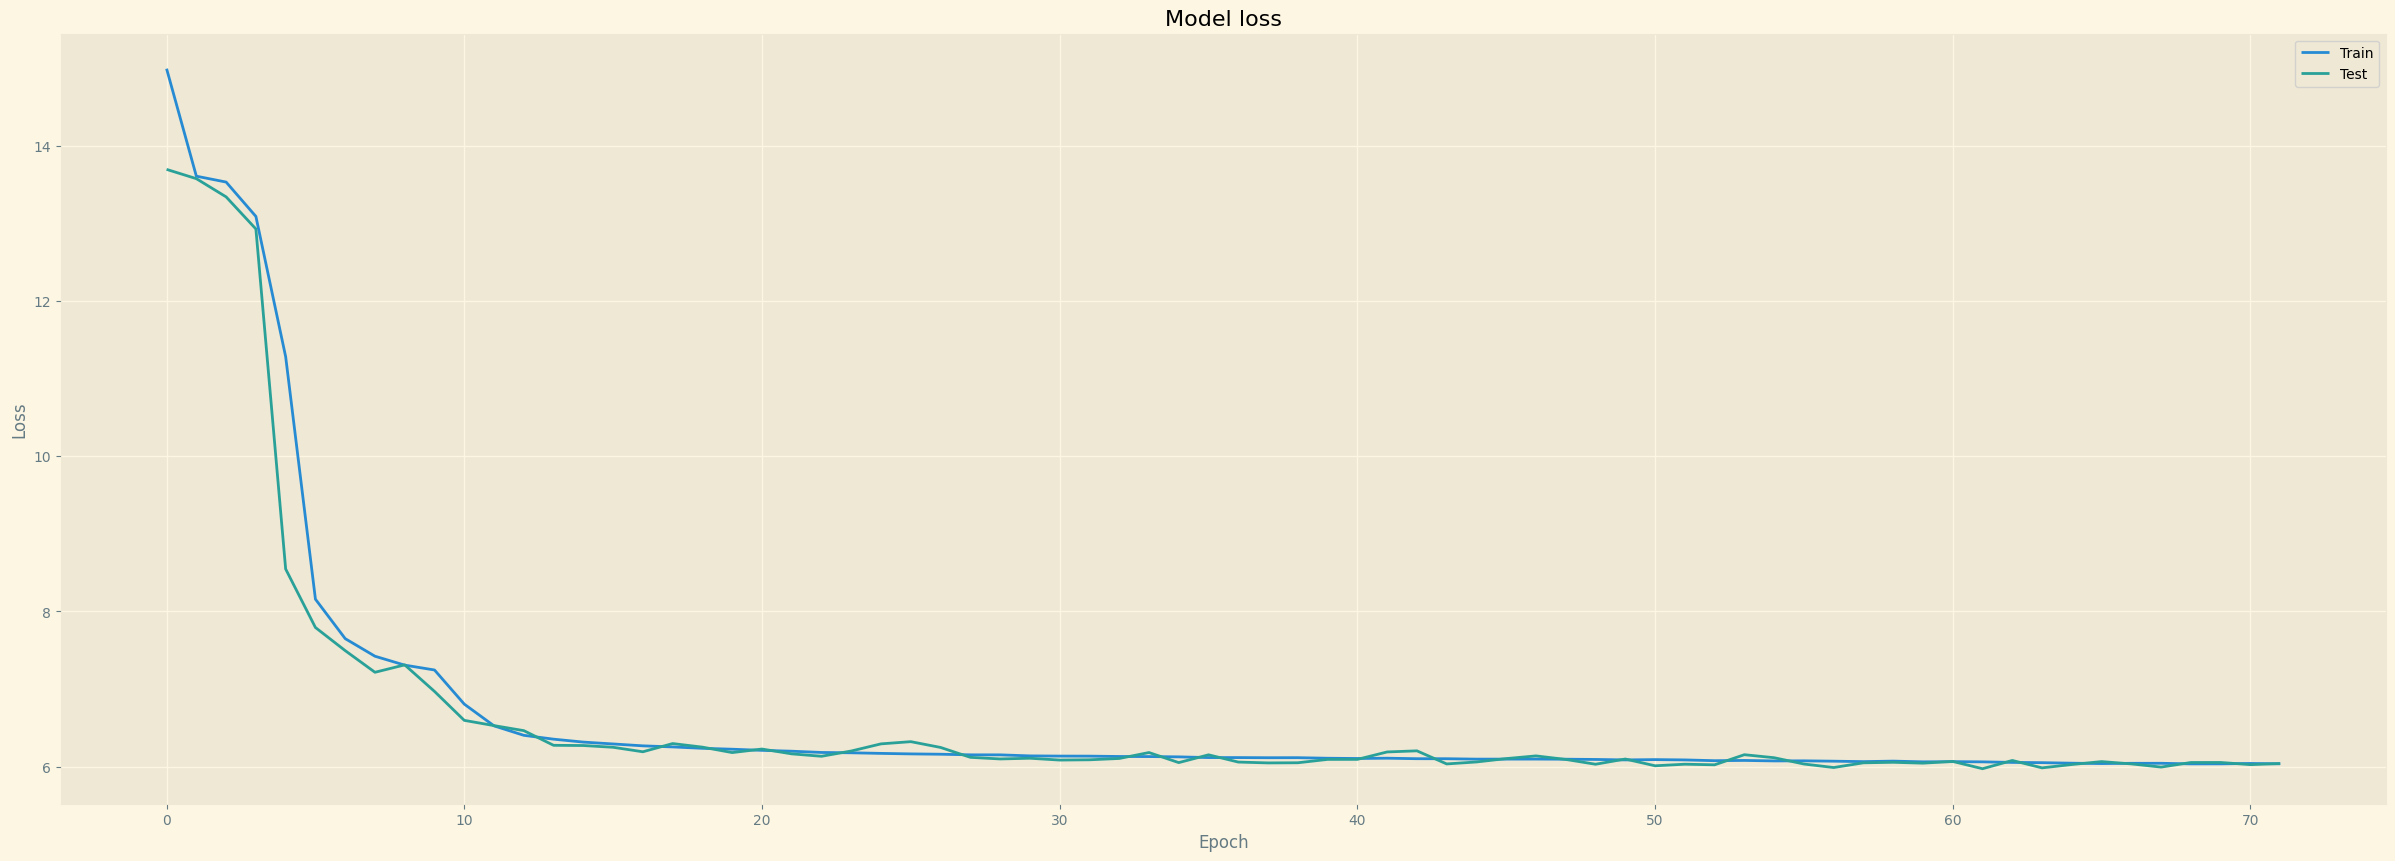

In [22]:
visualizer().loss_plot(history.history["loss"], history.history["val_loss"])